<a href="https://colab.research.google.com/github/bayu-wilson/Brain_Tumor_GAN/blob/main/Brain_Tumor_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN to synthesize and augment a medical image dataset

This is based off the Deep Convolutional Generative Adversarial Network (DCGAN) tutorial from the [Tensorflow website](https://www.tensorflow.org/tutorials/generative/dcgan) applied to Brain MRI Images from [this Kaggle dataset](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection). I will be using the Keras Sequential API to build this DCGAN.

## Background, objective, and overview
Patient privacy makes it difficult to acquire large amount of medical image data to test algorithms on. Therefore, it would be useful to synthesize more data based on a pre-existing dataset. In this project, I train a DCGAN to generate synthetic images of brain tumors from MRI scans.



## Loading and installing necessary packages

In [246]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import PIL
import glob
import imageio
from IPython import display

In [2]:
!pip install imageio

## Load and prepare dataset

I downloaded the dataset and put it in a personal Google Drive folder

In [749]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [750]:
MAIN_DIR = "/content/gdrive/MyDrive/GAN_brain_tumor/brain_tumor_dataset/yes" #directory contains 155 images of brains with tumors

In [251]:
def load_images(folder):
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (56,56))
            imgs.append(img)
            labels.append(target)
        except:
            print("Something went wrong")
            continue

    imgs = np.array(imgs)
    labels = np.array(labels)
    return imgs, labels

In [751]:
BUFFER_SIZE = 155
BATCH_SIZE = 20 #this matters a lot. Best results are when this number is <30.

train_images, _ = load_images(MAIN_DIR)
train_images = train_images.reshape(train_images.shape[0], 56, 56, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

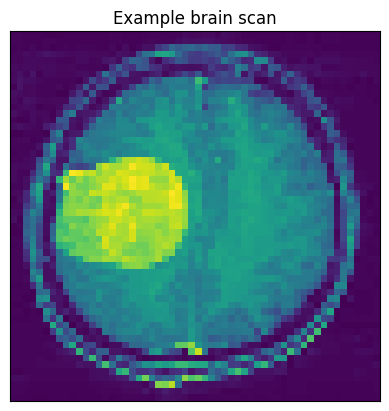

In [757]:
plt.imshow(train_images[1])
plt.yticks([])
plt.xticks([])
plt.title("Example brain scan");

## Define generator, discriminator, loss functions, and optimizers

In [760]:
def make_generator_model():
    filter_size = 5
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=[100,]))

    model.add(layers.Dense(14*14*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((14, 14, 256)))
    assert model.output_shape == (None, 14, 14, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (filter_size, filter_size), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (filter_size, filter_size), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (filter_size, filter_size), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 56, 56, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=[56, 56, 1]))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')) #  input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [761]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #arguments -> (truth, prediction)

In [762]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) #how well G can make fake image look real

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output)*0.9, real_output) #how well D can tell real image is real
    fake_loss = cross_entropy(tf.zeros_like(fake_output)+0.1, fake_output) #how well D can tell fake image is fake
    total_loss = real_loss + fake_loss
    return total_loss

In [763]:
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(2e-4)#1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)#8e-6)

checkpoint_dir = '/content/gdrive/MyDrive/GAN_brain_tumor/brain_tumor_dataset/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define training functions and parameters

In [768]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

# Seed reused over time
seed = tf.random.normal([num_examples_to_generate, noise_dim]) #16 by 100

In [769]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) #generate fake images

      real_output = discriminator(images, training=True) #classify whether or not "real images" are real
      fake_output = discriminator(generated_images, training=True) #classify whether or not "fake images" are real

      gen_loss = generator_loss(fake_output) #generator wants the fake_outputs to trick the discriminator
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [770]:
def train(dataset, epoch_start, epoch_end): #train(train_dataset, EPOCHS)
  gen_loss_arr = []
  disc_loss_arr = []
  for epoch in range(epoch_start,epoch_end):
    start = time.time()

    for image_batch in dataset:
      gen_loss,disc_loss = train_step(image_batch)
      gen_loss_arr.append(gen_loss)
      disc_loss_arr.append(disc_loss)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epoch_end,
                           seed)
  return gen_loss_arr,disc_loss_arr

In [771]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.suptitle(f"Epoch: {epoch:04d}")
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training the model

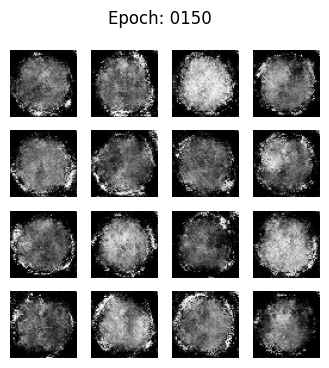

In [745]:
gen_loss_arr, disc_loss_arr = train(train_dataset, 0,EPOCHS)

## Tracking the generator and discriminator loss

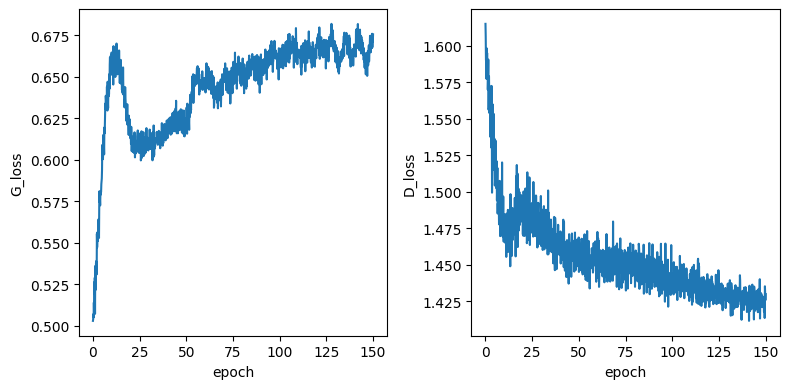

In [746]:
gen_loss = np.array(gen_loss_arr)
disc_loss = np.array(disc_loss_arr)
epochs = np.linspace(0,EPOCHS,len(gen_loss))
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
ax[0].plot(epochs,gen_loss)
ax[0].set_ylabel("G_loss")
ax[0].set_xlabel("epoch")

ax[1].plot(epochs,disc_loss)
ax[1].set_ylabel("D_loss")
ax[1].set_xlabel("epoch")
plt.tight_layout()
plt.savefig("/content/gdrive/MyDrive/GAN_brain_tumor/losses_test6.png")


## Useful code if you want to re-run from checkpoints

In [772]:
# epoch_start = int(tf.train.latest_checkpoint(checkpoint_dir).split("ckpt-")[1])*15
# print(epoch_start)
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# gen_loss_arr, disc_loss_arr = train(train_dataset, epoch_start,epoch_start+50)

## A GIF to show 16 synthesized brain scans

In [747]:
anim_file = '/content/gdrive/MyDrive/GAN_brain_tumor/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-747-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-747-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
